# Homework 2 - Data from the Web

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

from munkres import Munkres #To do the matching


## Question 1 - 

### Part 1 - Extracting the Data of the website

Using Postman Interceptor, we were able to find the json file containing all the data listed in the first table, including the url to the more detailled page for each university from which we can parse through the html code to get the remaining informations.

In [2]:
#TopUniversities.com
r = requests.get("https://www.topuniversities.com/sites/default/files/qs-rankings-data/357051.txt?_=1508602165358")
dic = r.json()['data']
dic[0]

{'cc': 'US',
 'core_id': '410',
 'country': 'United States',
 'guide': '<a href="/where-to-study/north-america/united-states/guide" class="guide-link" target="_blank">United States</a>',
 'logo': '<img src="https://www.topuniversities.com/sites/default/files/massachusetts-institute-of-technology-mit_410_small_0.jpg" alt="Massachusetts Institute of Technology (MIT)  Logo">',
 'nid': '294850',
 'rank_display': '1',
 'region': 'North America',
 'score': '100',
 'stars': '6',
 'title': 'Massachusetts Institute of Technology (MIT)',
 'url': '/universities/massachusetts-institute-technology-mit'}

In [3]:
for univ in dic[:200]:
    #Get information from the university dedicated page
    r2 = requests.get("https://www.topuniversities.com" + univ['url'])
    univ['soup'] = BeautifulSoup(r2.text, 'html.parser')

We also store the differents scores that were given, except the overall one as it is redundant, for a later use in question 5. Some universities don't have all these scores on the detailled page, so we have filled with NaN the remaining values.

As the scores are considered the same way, not having the score on the exact column is not a problem.

In [4]:
data_list = []
for univ in dic[:200]:
    #First page information
    row = {'Name':univ['title'],'Rank':univ['rank_display'],'Country':univ['country'],'Region':univ['region']}
    
    #Second page information
    try:
        row['Number of students'] = univ['soup'].find('div',class_ = "total student").find('div',class_="number").string[1:-1]
        row['Number of international students'] = univ['soup'].find('div',class_ = "total inter").find('div',class_="number").string[1:-1]
    
        list_score = list(map(lambda x:float(x.string),univ['soup'].find('ul',class_='score').find_all('div',class_='text')))[1:]
        list_score += [np.nan]*(6-len(list_score))
        row['Score_1'],row['Score_2'],row['Score_3'],row['Score_4'],row['Score_5'],row['Score_6'] = list_score
        row['Number of faculty members'] = univ['soup'].find('div',class_ = "total faculty").find('div',class_="number").string[1:-1]
        row['Number of international members'] = univ['soup'].find('div',class_ = "inter faculty").find('div',class_="number").string[1:-1]
    except:
        print(univ['title'], univ['rank_display'])
        
    data_list.append(row)

New York University (NYU) 52
Indian Institute of Science (IISc) Bangalore 190


As we see, some pages lack the data we need.

In [5]:
data_1 = pd.DataFrame(data_list)
data_1 = data_1[['Name','Rank','Country','Region','Number of faculty members','Number of international members','Number of students', 'Number of international students','Score_1','Score_2','Score_3','Score_4','Score_5','Score_6']]

### Part 2 - Modify the data types and add new columns

First we modify the data types when it is relevant ('rank' -> int, 'number of faculty members' -> int, ...)
We use '.apply' to the specific column to modify the data type, and also filter the string. For example '12,544' is filtered as 12544.

Then we add columns 'staff-students ratio' and 'int-students ratio' : we use 'number of faculty members' and 'number of students' to compute the 'staff-students ratio'. We do similarly for the other ratio.

In [6]:
## Modify the data types for the 1st data frame

# type: int BUT in practice type: float because some columns have NaN values and type(NaN)=float
data_1['Rank'] = data_1['Rank'].apply(lambda x : int(x.replace('=','')))
data_1['Number of faculty members'] = data_1['Number of faculty members'].apply(lambda x : int(x.replace(',','')) if type(x)== str else np.nan)
data_1['Number of international members'] = data_1['Number of international members'].apply(lambda x : int(x.replace(',','')) if type(x)== str else np.nan)
data_1['Number of students'] = data_1['Number of students'].apply(lambda x : int(x.replace(',','')) if type(x)== str else np.nan)
data_1['Number of international students'] = data_1['Number of international students'].apply(lambda x : int(x.replace(',','')) if type(x)== str else np.nan)

## Add columns which are consistent with the first data_frame

# Number of faculty members (type: int)
data_1['staff-students ratio'] = data_1['Number of faculty members'] / data_1['Number of students']

# Number of international students (type: int)
data_1['int-students ratio'] = data_1['Number of international students'] /data_1['Number of students']
data_1

,Name,Rank,Country,Region,Number of faculty members,Number of international members,Number of students,Number of international students,Score_1,Score_2,Score_3,Score_4,Score_5,Score_6,staff-students ratio,int-students ratio
0,Massachusetts Institute of Technology (MIT),1,United States,North America,2982.0,1679.0,11067.0,3717.0,100.0,99.9,100.0,100.0,100.0,96.1,0.269450,0.335863
1,Stanford University,2,United States,North America,4285.0,2042.0,15878.0,3611.0,100.0,99.4,100.0,100.0,99.6,72.7,0.269870,0.227422
2,Harvard University,3,United States,North America,4350.0,1311.0,22429.0,5266.0,100.0,99.9,100.0,98.3,96.5,75.2,0.193945,0.234785
3,California Institute of Technology (Caltech),4,United States,North America,953.0,350.0,2255.0,647.0,99.5,100.0,85.4,100.0,93.4,89.2,0.422616,0.286918
4,University of Cambridge,5,United Kingdom,Europe,5490.0,2278.0,18770.0,6699.0,100.0,78.3,100.0,100.0,97.4,97.7,0.292488,0.356899
5,University of Oxford,6,United Kingdom,Europe,6750.0,2964.0,19720.0,7353.0,100.0,76.3,100.0,100.0,98.6,98.5,0.342292,0.372870
6,UCL (University College London),7,United Kingdom,Europe,6345.0,2554.0,31080.0,14854.0,99.7,74.7,99.5,99.1,96.6,100.0,0.204151,0.477928
7,Imperial College London,8,United Kingdom,Europe,3930.0,2071.0,16090.0,8746.0,99.4,68.7,100.0,100.0,100.0,100.0,0.244251,0.543567
8,University of Chicago,9,United States,North America,2449.0,635.0,13557.0,3379.0,99.9,85.9,92.9,96.5,71.9,79.8,0.180645,0.249244
9,ETH Zurich - Swiss Federal Institute of Techno...,10,Switzerland,Europe,2477.0,1886.0,19815.0,7563.0,99.6,98.7,99.4,68.2,100.0,98.8,0.125006,0.381681


### Part 3 - Charts and discussion

The plots work similarly for each ratio. Here is a detail of the code for the staff-students ratio:

- Best universities: we sort by the ratio and plot the head() of the dataframe
- Best country: we group by country, sum the columns 'Number of faculty members' and 'Number of students', and re-compute the ratio
- Best region: we group by region, sum the columns 'Number of faculty members' and'Number of students', and re-compute the ratio

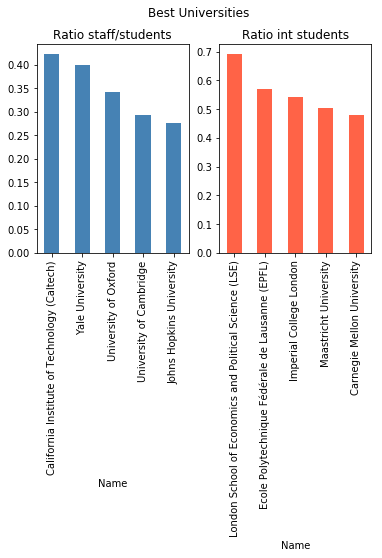

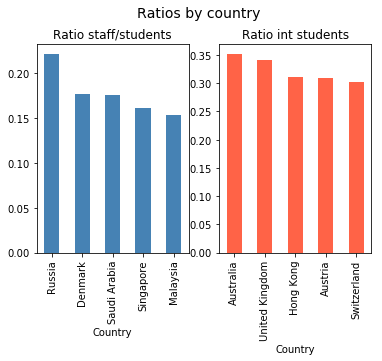

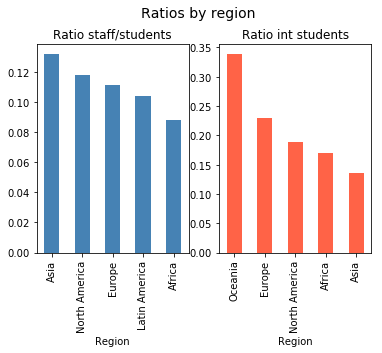

In [7]:
## Plot the Best universities for each ratio
fig, axes = plt.subplots(nrows=1, ncols=2)
plt.subplots_adjust(top=.85)
fig.suptitle("Best Universities", fontsize=12)

g1 = data_1.sort_values(by='staff-students ratio',ascending=False)
g1.head().set_index('Name')['staff-students ratio'].plot(kind='bar', color='steelblue', ax=axes[0], title ="Ratio staff/students")

g2 = data_1.sort_values(by='int-students ratio',ascending=False)
g2.head().set_index('Name')['int-students ratio'].plot(kind='bar', color='tomato', ax=axes[1], title ="Ratio int students")

plt.show()


## Group by country
fig, axes = plt.subplots(nrows=1, ncols=2)
plt.subplots_adjust(top=.85)
fig.suptitle("Ratios by country", fontsize=14)

g1 = data_1.groupby('Country')[['Number of faculty members','Number of students']].sum()
g1['staff-students ratio'] = g1['Number of faculty members'] / g1['Number of students']
g1 = g1.sort_values(by='staff-students ratio',ascending=False)
g1.head()['staff-students ratio'].plot(kind='bar', color='steelblue', ax=axes[0], title ="Ratio staff/students")

g2 = data_1.groupby('Country')[['Number of international students','Number of students']].sum()
g2['int-students ratio'] = g2['Number of international students'] / g2['Number of students']
g2 = g2.sort_values(by='int-students ratio',ascending=False)
g2.head()['int-students ratio'].plot(kind='bar', color='tomato', ax=axes[1], title ="Ratio int students")

plt.show()

## Group by region
fig, axes = plt.subplots(nrows=1, ncols=2)
plt.subplots_adjust(top=.85)
fig.suptitle("Ratios by region", fontsize=14)

g1 = data_1.groupby('Region')[['Number of faculty members','Number of students']].sum()
g1['staff-students ratio'] = g1['Number of faculty members'] / g1['Number of students']
g1 = g1.sort_values(by='staff-students ratio',ascending=False)
g1.head()['staff-students ratio'].plot(kind='bar', color='steelblue', ax=axes[0], title ="Ratio staff/students")

g2 = data_1.groupby('Region')[['Number of international students','Number of students']].sum()
g2['int-students ratio'] = g2['Number of international students'] / g2['Number of students']
g2 = g2.sort_values(by='int-students ratio',ascending=False)
g2.head()['int-students ratio'].plot(kind='bar', color='tomato', ax=axes[1], title ="Ratio int students")

plt.show()




We observe that EPFL has a pretty good ratio of international students, as well as Switzerland in general.

For the graphs of staff/students ratio, we see that the best universities for the ratio are not in the best countries for the ratio. This means this ratio is very specific to the school, and can be very different for numerous schools in the same country.

## Question 2 -

### Part 1 - extracting the data

This time, no extra page were required. All the information we need are in the json file.

In [8]:
##TimesHigherEducation

r3 = requests.get("https://www.timeshighereducation.com/sites/default/files/the_data_rankings/world_university_rankings_2018_limit0_369a9045a203e176392b9fb8f8c1cb2a.json")
list_univ = r3.json()['data']
list_univ[0]

{'aliases': 'University of Oxford',
 'location': 'United Kingdom',
 'member_level': '0',
 'name': 'University of Oxford',
 'nid': 468,
 'rank': '1',
 'rank_order': '10',
 'record_type': 'master_account',
 'scores_citations': '99.1',
 'scores_citations_rank': '15',
 'scores_industry_income': '63.7',
 'scores_industry_income_rank': '169',
 'scores_international_outlook': '95.0',
 'scores_international_outlook_rank': '24',
 'scores_overall': '94.3',
 'scores_overall_rank': '10',
 'scores_research': '99.5',
 'scores_research_rank': '1',
 'scores_teaching': '86.7',
 'scores_teaching_rank': '5',
 'stats_female_male_ratio': '46 : 54',
 'stats_number_students': '20,409',
 'stats_pc_intl_students': '38%',
 'stats_student_staff_ratio': '11.2',
 'subjects_offered': 'Archaeology,Art, Performing Arts & Design,Biological Sciences,Business & Management,Chemical Engineering,Chemistry,Civil Engineering,Computer Science,Economics & Econometrics,Electrical & Electronic Engineering,General Engineering,Geo

In [9]:
data_2 = pd.DataFrame(list_univ[:200])
data_2 = data_2[['name','location','rank','stats_number_students','stats_pc_intl_students','stats_student_staff_ratio','scores_citations','scores_industry_income','scores_international_outlook','scores_research','scores_teaching']]
data_2.columns = ['Name','Country','Rank','Number of students','Percentage of international students','Students-Staff ratio','Score_7','Score_8','Score_9','Score_10','Score_11']
data_2[['Score_'+str(i) for i in range(7,12)]] = data_2[['Score_'+str(i) for i in range(7,12)]].apply(pd.to_numeric)

### Part 2 - Modify the data types and add new columns

We proceed similarly to part 1.

First we modify the data types when it is relevant ('rank' -> int, 'number of faculty members' -> int, ...)
We use '.apply' to the specific column to modify the data type, and also filter the string. For example '12,544' is filtered as 12544.

Then we add columns 'staff-students ratio' and 'int-students ratio'.

We also add columns 'Number of faculty members' and 'Number of international students' to have consistent data with the first dataframe. For the region column, we create a dictionary {country:region}.

In [10]:
## Modify the data types for the 2nd data frame

# type: int
data_2['Rank'] = data_2['Rank'].apply(lambda x : int(x.replace('=','')))
data_2['Number of students'] = data_2['Number of students'].apply(lambda x : int(x.replace(',','')))

# type: float
data_2['Percentage of international students'] = data_2['Percentage of international students'].apply(lambda x : float(x.replace('%','')))
data_2['Students-Staff ratio'] = data_2['Students-Staff ratio'].apply(lambda x : float(x))


## Add ratio columns

# Number of faculty members (type: int)
data_2['staff-students ratio'] = 1 / data_2['Students-Staff ratio']

# Number of international students (type: int)
data_2['int-students ratio'] = data_2['Percentage of international students'] /100


## Add columns which are consistent with the first data_frame

# Number of faculty members (type: int)
data_2['Number of faculty members'] = data_2['Number of students'] / data_2['Students-Staff ratio']
data_2['Number of faculty members'] = data_2['Number of faculty members'].apply(lambda x : int(x))

# Number of international students (type: int)
data_2['Number of international students'] = data_2['Number of students'] *data_2['Percentage of international students'] /100
data_2['Number of international students'] = data_2['Number of international students'].apply(lambda x : int(x))

In [11]:
dict_region = {'Argentina': 'Latin America','Australia': 'Oceania',
'Austria': 'Europe','Belgium': 'Europe',
'Brazil': 'Latin America','Canada': 'North America',
'Chile': 'Latin America','China': 'Asia','Denmark': 'Europe',
'Finland': 'Europe','France': 'Europe','Germany': 'Europe',
'Hong Kong': 'Asia','India': 'Asia','Ireland': 'Europe','Israel': 'Asia',
'Italy': 'Europe','Japan': 'Asia','Malaysia': 'Asia','Mexico': 'Latin America',
'Netherlands': 'Europe','New Zealand': 'Oceania','Norway': 'Europe','Russian Federation': 'Europe',
'Saudi Arabia': 'Asia','Singapore': 'Asia','South Africa': 'Africa','South Korea': 'Asia',
'Spain': 'Europe','Sweden': 'Europe','Switzerland': 'Europe','Taiwan': 'Asia',
'United Kingdom': 'Europe','United States': 'North America', 'Luxembourg': 'Europe'}

In [12]:
data_2['Region'] = data_2['Country']
data_2 = data_2.replace({'Region': dict_region})
data_2

,Name,Country,Rank,Number of students,Percentage of international students,Students-Staff ratio,Score_7,Score_8,Score_9,Score_10,Score_11,staff-students ratio,int-students ratio,Number of faculty members,Number of international students,Region
0,University of Oxford,United Kingdom,1,20409,38.0,11.2,99.1,63.7,95.0,99.5,86.7,0.089286,0.38,1822,7755,Europe
1,University of Cambridge,United Kingdom,2,18389,35.0,10.9,97.5,51.5,93.0,97.8,87.8,0.091743,0.35,1687,6436,Europe
2,California Institute of Technology,United States,3,2209,27.0,6.5,99.5,92.6,59.7,97.5,90.3,0.153846,0.27,339,596,North America
3,Stanford University,United States,3,15845,22.0,7.5,99.9,60.5,77.6,96.7,89.1,0.133333,0.22,2112,3485,North America
4,Massachusetts Institute of Technology,United States,5,11177,34.0,8.7,100.0,88.4,87.6,91.9,87.3,0.114943,0.34,1284,3800,North America
5,Harvard University,United States,6,20326,26.0,8.9,99.7,46.4,79.7,98.4,84.2,0.112360,0.26,2283,5284,North America
6,Princeton University,United States,7,7955,24.0,8.3,99.6,58.0,78.7,93.9,85.7,0.120482,0.24,958,1909,North America
7,Imperial College London,United Kingdom,8,15857,55.0,11.4,96.7,71.6,96.6,88.7,81.7,0.087719,0.55,1390,8721,Europe
8,University of Chicago,United States,9,13525,25.0,6.2,99.4,39.8,69.6,90.1,85.3,0.161290,0.25,2181,3381,North America
9,ETH Zurich – Swiss Federal Institute of Techno...,Switzerland,10,19233,38.0,14.6,94.3,60.3,98.1,92.0,76.4,0.068493,0.38,1317,7308,Europe


### Part 3 - Charts and discussion

The plots work similarly for each ratio. Here is a detail of the code for the staff-students ratio:

- Best universities: we sort by the ratio and plot the head() of the dataframe
- Best country: we group by country, sum the columns 'Number of faculty members' and 'Number of students', and re-compute the ratio
- Best region: we group by region, then sum the columns 'Number of faculty members' and'Number of students', and re-compute the ratio



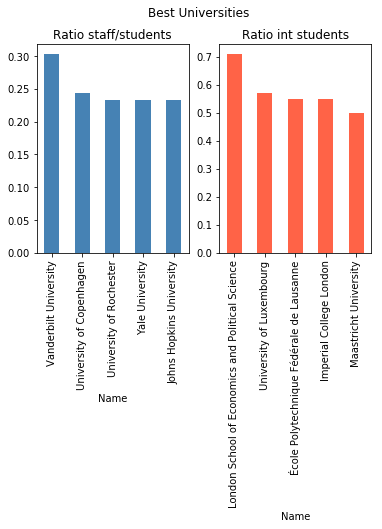

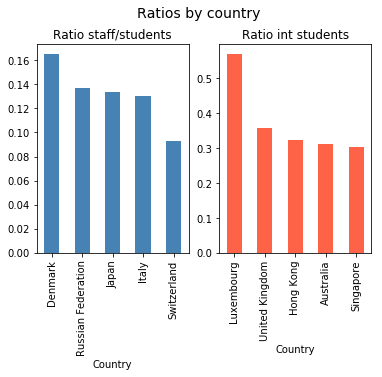

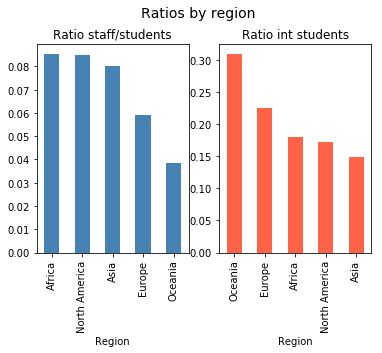

In [13]:
## Plot the Best universities for each ratio
fig, axes = plt.subplots(nrows=1, ncols=2)
plt.subplots_adjust(top=.85)
fig.suptitle("Best Universities", fontsize=12)

g1 = data_2.sort_values(by='staff-students ratio',ascending=False)
g1.head().set_index('Name')['staff-students ratio'].plot(kind='bar', color='steelblue', ax=axes[0], title ="Ratio staff/students")

g2 = data_2.sort_values(by='int-students ratio',ascending=False)
g2.head().set_index('Name')['int-students ratio'].plot(kind='bar', color='tomato', ax=axes[1], title ="Ratio int students")

plt.show()


## Group by country
fig, axes = plt.subplots(nrows=1, ncols=2)
plt.subplots_adjust(top=.85)
fig.suptitle("Ratios by country", fontsize=14)

g1 = data_2.groupby('Country')[['Number of faculty members','Number of students']].sum()
g1['staff-students ratio'] = g1['Number of faculty members'] / g1['Number of students']
g1 = g1.sort_values(by='staff-students ratio',ascending=False)
g1.head()['staff-students ratio'].plot(kind='bar', color='steelblue', ax=axes[0], title ="Ratio staff/students")

g2 = data_2.groupby('Country')[['Number of international students','Number of students']].sum()
g2['int-students ratio'] = g2['Number of international students'] / g2['Number of students']
g2 = g2.sort_values(by='int-students ratio',ascending=False)
g2.head()['int-students ratio'].plot(kind='bar', color='tomato', ax=axes[1], title ="Ratio int students")

plt.show()

## Group by region
fig, axes = plt.subplots(nrows=1, ncols=2)
plt.subplots_adjust(top=.85)
fig.suptitle("Ratios by region", fontsize=14)

g1 = data_2.groupby('Region')[['Number of faculty members','Number of students']].sum()
g1['staff-students ratio'] = g1['Number of faculty members'] / g1['Number of students']
g1 = g1.sort_values(by='staff-students ratio',ascending=False)
g1.head()['staff-students ratio'].plot(kind='bar', color='steelblue', ax=axes[0], title ="Ratio staff/students")

g2 = data_2.groupby('Region')[['Number of international students','Number of students']].sum()
g2['int-students ratio'] = g2['Number of international students'] / g2['Number of students']
g2 = g2.sort_values(by='int-students ratio',ascending=False)
g2.head()['int-students ratio'].plot(kind='bar', color='tomato', ax=axes[1], title ="Ratio int students")

plt.show()




We observe that the values are slightly different from the first tables.
Once again, small countries get better average ratios because there are less representative universities.

# Question 3

To check if two university names correspond to the same university, we use the levenshtein distance over the length of the name to prevent penalizing long university names. It is also useful as after the normalization, this distance is always between 0 and 1.

We also compressed common words - 'University' and 'Institute' - as they were biasing the length for very small names.

In [14]:
#Wikibooks
def levenshtein(s1, s2):
    if len(s1) < len(s2):
        return levenshtein(s2, s1)

    # len(s1) >= len(s2)
    if len(s2) == 0:
        return len(s1)

    previous_row = range(len(s2) + 1)
    for i, c1 in enumerate(s1):
        current_row = [i + 1]
        for j, c2 in enumerate(s2):
            insertions = previous_row[j + 1] + 1 # j+1 instead of j since previous_row and current_row are one character longer
            deletions = current_row[j] + 1       # than s2
            substitutions = previous_row[j] + (c1 != c2)
            current_row.append(min(insertions, deletions, substitutions))
        previous_row = current_row
    
    return previous_row[-1]/max(len(s1),len(s2))

Then we merge the two dataframes considering all possible pairs of names.
To keep only pertinent ones, we truncated it so that we have only those with a distance less than 0.4.

In [15]:
data_1['dummy'] = 1
data_2['dummy'] = 1
#Compressing 'University' and 'Institute'
data_1['Name'] = data_1['Name'].apply(lambda x: x.replace('University','%').replace('Institute','#'))
data_2['Name'] = data_2['Name'].apply(lambda x: x.replace('University','%').replace('Institute','#'))

merge_data = pd.merge(data_1,data_2,on=['dummy'],suffixes=['_1','_2'])
merge_data['dist'] = merge_data.apply(lambda x: levenshtein(x['Name_1'],x['Name_2']),axis = 1)

data_tronc = merge_data[merge_data['dist'] < 0.4][['Name_1','Name_2','dist']]

This truncation gives us differents pairs that overlap.

To get only one, we use the hungarian algorithm to get a maximum matching with minimum distance.
To use the library we have to have dummy vertices on both sides so that the matrix is square-shaped.

In [16]:
m = Munkres()
names_1 = list(set(data_tronc['Name_1']))
names_2 = list(set(data_tronc['Name_2']))
index_1 = {val:i for i,val in enumerate(names_1)}
index_2 = {val:i for i,val in enumerate(names_2)}
matrix = [[1]*(len(names_1) + len(names_2)) for x in [0]*(len(names_1) + len(names_2))]

for ind,x in data_tronc.iterrows():
    matrix[index_1[x['Name_1']]][index_2[x['Name_2']]] = x['dist']
indexes = m.compute(matrix)
    
pair = [[names_1[i],names_2[j]] for i,j in indexes if i < len(names_1) and j < len(names_2) and matrix[i][j] < 0.4]

match_pair = pd.DataFrame(pair)
match_pair.columns = ['Name_1','Name_2']
match_pair

,Name_1,Name_2
0,Fudan %,Fudan %
1,Durham %,Durham %
2,% of Helsinki,% of Helsinki
3,% of Twente,% of Twente
4,City % of Hong Kong,City % of Hong Kong
5,Cornell %,Cornell %
6,KAIST - Korea Advanced # of Science & Technology,Korea Advanced # of Science and Technology (KA...
7,Sungkyunkwan % (SKKU),Sungkyunkwan % (SKKU)
8,% of Southern California,% of Southern California
9,% of British Columbia,% of British Columbia


Using the pairs, we can merge the two dataframes data_1 and data_2, to get an unified one with only the universities that appear in both dataframes.

As our matching is still not perfect, we add the following constraints that a university can only be in one country.

In [17]:
data_1.columns = ['Name_1'] + list(data_1.columns)[1:]
data_2.columns = ['Name_2'] + list(data_2.columns)[1:]

data_left = pd.merge(data_1,match_pair,how='outer')

data_right = pd.merge(data_2,match_pair,how='outer')

data_combined = pd.merge(data_left,data_right,how='outer',on=['Name_1','Name_2'],suffixes=['_1','_2'])
data_combined = data_combined[data_combined['Country_1'] == data_combined['Country_2']]
data_combined = data_combined[['Name_1','Rank_1','Rank_2','Country_1','Region_1','Number of students_1','Number of students_2','Number of faculty members_1','Number of faculty members_2','Students-Staff ratio','Number of international members','Percentage of international students','Score_1','Score_2','Score_3','Score_4','Score_5','Score_6','Score_7','Score_8','Score_9','Score_10','Score_11']]
data_combined['Name_1'] = data_combined['Name_1'].apply(lambda x: x.replace('%','University').replace('#','Institute'))
data_combined

,Name_1,Rank_1,Rank_2,Country_1,Region_1,Number of students_1,Number of students_2,Number of faculty members_1,Number of faculty members_2,Students-Staff ratio,...,Score_2,Score_3,Score_4,Score_5,Score_6,Score_7,Score_8,Score_9,Score_10,Score_11
0,Massachusetts Institute of Technology (MIT),1.0,5.0,United States,North America,11067.0,11177.0,2982.0,1284.0,8.7,...,99.9,100.0,100.0,100.0,96.1,100.0,88.4,87.6,91.9,87.3
1,Stanford University,2.0,3.0,United States,North America,15878.0,15845.0,4285.0,2112.0,7.5,...,99.4,100.0,100.0,99.6,72.7,99.9,60.5,77.6,96.7,89.1
2,Harvard University,3.0,6.0,United States,North America,22429.0,20326.0,4350.0,2283.0,8.9,...,99.9,100.0,98.3,96.5,75.2,99.7,46.4,79.7,98.4,84.2
3,California Institute of Technology (Caltech),4.0,3.0,United States,North America,2255.0,2209.0,953.0,339.0,6.5,...,100.0,85.4,100.0,93.4,89.2,99.5,92.6,59.7,97.5,90.3
4,University of Cambridge,5.0,2.0,United Kingdom,Europe,18770.0,18389.0,5490.0,1687.0,10.9,...,78.3,100.0,100.0,97.4,97.7,97.5,51.5,93.0,97.8,87.8
5,University of Oxford,6.0,1.0,United Kingdom,Europe,19720.0,20409.0,6750.0,1822.0,11.2,...,76.3,100.0,100.0,98.6,98.5,99.1,63.7,95.0,99.5,86.7
6,UCL (University College London),7.0,16.0,United Kingdom,Europe,31080.0,30304.0,6345.0,2886.0,10.5,...,74.7,99.5,99.1,96.6,100.0,94.6,41.2,94.6,88.2,74.4
7,Imperial College London,8.0,8.0,United Kingdom,Europe,16090.0,15857.0,3930.0,1390.0,11.4,...,68.7,100.0,100.0,100.0,100.0,96.7,71.6,96.6,88.7,81.7
8,University of Chicago,9.0,9.0,United States,North America,13557.0,13525.0,2449.0,2181.0,6.2,...,85.9,92.9,96.5,71.9,79.8,99.4,39.8,69.6,90.1,85.3
9,ETH Zurich - Swiss Federal Institute of Techno...,10.0,10.0,Switzerland,Europe,19815.0,19233.0,2477.0,1317.0,14.6,...,98.7,99.4,68.2,100.0,98.8,94.3,60.3,98.1,92.0,76.4


# Question 5

To evaluate universities, we have considered that all different score given by the two websites have their significance, and even more if both consider it.
Therefore, we computed the mean for all 11 scores for each university and gave their new rank accordingly.

In [18]:
data_combined['Our Score'] = data_combined[['Score_' + str(i) for i in range(1,12)]].mean(axis = 1)

#We reset the index after sorting so that it represents the rank
data_combined = data_combined.sort_values('Our Score',ascending=False).reset_index()[['Name_1','Rank_1','Rank_2','Our Score']]
data_combined.index = data_combined.index + 1
data_combined.index.name = 'Our rank'
data_combined

,Name_1,Rank_1,Rank_2,Our Score
Our rank,,,,
1,Massachusetts Institute of Technology (MIT),1.0,5.0,95.563636
2,University of Oxford,6.0,1.0,92.490909
3,California Institute of Technology (Caltech),4.0,3.0,91.554545
4,Imperial College London,8.0,8.0,91.218182
5,University of Cambridge,5.0,2.0,91.000000
6,Stanford University,2.0,3.0,90.500000
7,ETH Zurich - Swiss Federal Institute of Techno...,10.0,10.0,89.618182
8,Harvard University,3.0,6.0,88.936364
9,Ecole Polytechnique Fédérale de Lausanne (EPFL),12.0,38.0,87.654545
